In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from random import shuffle
from torch import nn
import torchvision as TV
from torch.utils.tensorboard import SummaryWriter
from collections import deque
from tqdm import tqdm

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
mnist_data = TV.datasets.MNIST("MNIST/", train=True, transform=None,\
                                        target_transform=None, download=True) 
mnist_test = TV.datasets.MNIST("MNIST/", train=False, transform=None,\
                                        target_transform=None, download=True) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [4]:
print(mnist_data.data.shape)
print(mnist_data.targets.shape)
print(mnist_test.data.shape)
print(mnist_test.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [5]:
def running_mean(x,w=50,step=1):
    c = 1.0/w
    conv = np.array([c]).repeat(w)
    output = []
    s,e = 0,w
    for i in range(x.shape[0]):
        sub = x[s:e]
        if sub.shape[0] < w:
            break
        tmp = conv @ sub
        output.append(tmp)
        s = s + step
        e = s + w
    return np.array(output)

In [6]:
def add_spots(x,m=20,std=5,val=1): 
    mask = torch.zeros(x.shape)
    N = int(m + std * np.abs(np.random.randn()))
    ids = np.random.randint(np.prod(x.shape),size=N)
    mask.view(-1)[ids] = val
    return torch.clamp(x + mask,0,1)

def prepare_images(xt,maxtrans=6,rot=5,noise=10):
    out = torch.zeros(xt.shape)
    for i in range(xt.shape[0]):
        img = xt[i].unsqueeze(dim=0)
        img = TV.transforms.functional.to_pil_image(img)
        rand_rot = int(np.random.randint(-1*rot,rot,1)) if rot > 0 else 0
        xtrans,ytrans = np.random.randint(-maxtrans,maxtrans,2)
        img = TV.transforms.functional.affine(img, rand_rot, (xtrans,ytrans),1,0)
        img = TV.transforms.functional.to_tensor(img).squeeze()
        if noise > 0:
            img = add_spots(img,m=noise)
        maxval = img.view(-1).max()
        if maxval > 0:
            img = img.float() / maxval
        else:
            img = img.float()
        out[i] = img
    return out

torch.Size([6, 28, 28])
torch.Size([6, 1, 28, 28])


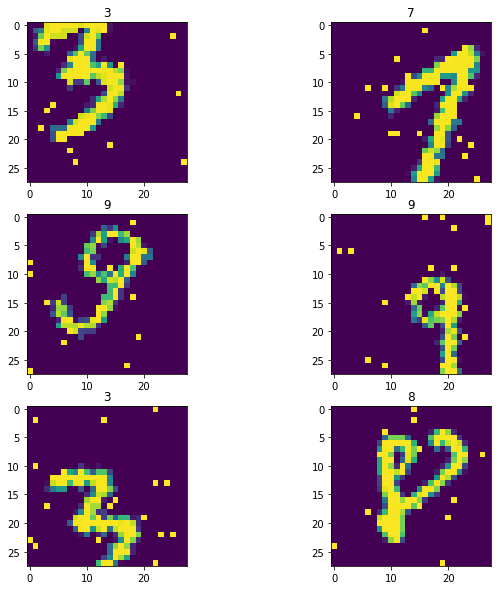

In [7]:
batch_size = 6
batch_ids = np.random.randint(0,60000,size=batch_size)
samples = mnist_data.data[batch_ids].detach()
labels = mnist_data.targets[batch_ids].detach()
print(samples.shape)
samples = prepare_images(samples,rot=30).unsqueeze(dim=1)
print(samples.shape)
samples = samples.cpu().detach().numpy()
plt.figure(figsize=(10,10))
for i, (img, label) in enumerate(zip(samples, labels)):
  plt.subplot(3,2,i+1)
  plt.title(label.item())
  plt.imshow(img.squeeze())

In [8]:
class RelationalModule(torch.nn.Module):
    def __init__(self):
        super(RelationalModule, self).__init__()
        # Defines the number of channels for each convolutional layer
        self.ch_in = 1
        self.conv1_ch = 16 
        self.conv2_ch = 20 #dim `F` in paper
        self.conv3_ch = 24
        self.conv4_ch = 30
        #self.H and self.W are the height and width of the input image, respectively.
        self.H = 28
        self.W = 28
        self.node_size = 36 #dim `E`, The dimension of the nodes after passing through the relational module
        self.lin_hid = 100
        self.out_dim = 10
        self.sp_coord_dim = 2
        self.N = int(16**2) #The number of objects or nodes, which is just the number of pixels after passing through the convolutions
        #
        self.conv1 = nn.Conv2d(self.ch_in,self.conv1_ch,kernel_size=(4,4)).to(device)
        self.conv2 = nn.Conv2d(self.conv1_ch,self.conv2_ch,kernel_size=(4,4)).to(device)
        self.conv3 = nn.Conv2d(self.conv2_ch,self.conv3_ch,kernel_size=(4,4)).to(device)
        self.conv4 = nn.Conv2d(self.conv3_ch,self.conv4_ch,kernel_size=(4,4)).to(device)
        #
        self.proj_shape = (self.conv4_ch+self.sp_coord_dim,self.node_size) #The dimensionality of each node vector is the number of channels in the last convolution plus 2 spatial dimensions.
        self.k_proj = nn.Linear(*self.proj_shape).to(device)
        self.q_proj = nn.Linear(*self.proj_shape).to(device)
        self.v_proj = nn.Linear(*self.proj_shape).to(device)
        #
        self.node_shape = (self.N,self.node_size)
        #
        # self.k_lin = nn.Linear(self.node_size,self.N).to(device)
        # self.q_lin = nn.Linear(self.node_size,self.N).to(device)
        #
        
        self.k_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True).to(device)
        self.q_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True).to(device)
        self.v_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True).to(device)
        #
        self.linear1 = nn.Linear(self.node_size, self.node_size).to(device)
        self.norm1 = nn.LayerNorm(self.node_shape, elementwise_affine=False).to(device)
        self.linear2 = nn.Linear(self.node_size, self.out_dim).to(device)
    
    def forward(self,x):
        """
        `x` is a tensor (Batch_Size, C_{in}, Depth=1, Ht, Wt)
        """
        N, Cin, H, W = x.shape
        x = self.conv1(x) 
        x = torch.relu(x)
        x = self.conv2(x) 
        # x = x.squeeze() 
        x = torch.relu(x) 
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = torch.relu(x)

        _,_,cH,cW = x.shape
        xcoords = torch.arange(cW).repeat(cH,1).float().to(device) / cW
        ycoords = torch.arange(cH).repeat(cW,1).transpose(1,0).float().to(device) / cH
        spatial_coords = torch.stack([xcoords,ycoords],dim=0)
        spatial_coords = spatial_coords.unsqueeze(dim=0)
        spatial_coords = spatial_coords.repeat(N,1,1,1)
        x = torch.cat([x,spatial_coords],dim=1)
        x = x.permute(0,2,3,1)
        x = x.flatten(1,2)
        
        K = self.k_proj(x)
        K = self.k_norm(K) 
        
        Q = self.q_proj(x)
        Q = self.q_norm(Q) 
        
        V = self.v_proj(x)
        V = self.v_norm(V) 
        A = torch.einsum('bfe,bge->bfg',Q,K) 
        A = A / np.sqrt(self.node_size)
        #A = torch.nn.functional.elu(self.q_lin(Q) + self.k_lin(K))
        A = torch.nn.functional.softmax(A,dim=2) 
        with torch.no_grad():
            self.att_map = A.cpu().detach()
        E = torch.einsum('bfc,bcd->bfd',A,V)
        E = self.linear1(E)
        E = torch.relu(E)
        E = self.norm1(E)
        # E = E.max(dim=1)[0]
        E = E.mean(dim=1)
        y = self.linear2(E)
        y = torch.nn.functional.log_softmax(y,dim=1)
        return y

In [9]:
RelationalModule()(torch.randn(2,1,28,28).to(device)).shape

torch.Size([2, 10])

In [10]:
#Test train on MNIST
def train(model, lr=1e-3, batch_size=300, epochs=2000):
  # writer = SummaryWriter()
  lossfn = nn.NLLLoss()
  opt = torch.optim.Adam(params=model.parameters(),lr=lr)
  losses = []
  acc = []
  for i in tqdm(range(epochs)):
      opt.zero_grad()
      batch_ids = np.random.randint(0,60000,size=batch_size)
      xt = mnist_data.data[batch_ids].detach()
      xt = prepare_images(xt,rot=30).unsqueeze(dim=1) #add chanel dimension
      yt = mnist_data.targets[batch_ids].detach()
      #
      pred = model(xt.cuda()).cpu()
      pred_labels = torch.argmax(pred,dim=1)
      acc_ = 100.0 * (pred_labels == yt).sum() / batch_size
      acc.append(acc_)
      # correct = torch.zeros(batch_size,10)
      # rows = torch.arange(batch_size).long()
      # correct[[rows,yt.detach().long()]] = 1.
      loss = lossfn(pred,yt)
      losses.append(loss.detach().numpy())
      # writer.add_scalar('Loss/train', loss.detach().numpy(), i)
      # writer.add_scalar('Acc/train', acc_.detach().numpy(), i)
      loss.backward()
      opt.step()
  losses = np.array(losses)
  acc = np.array(acc)
  return model,losses, acc

In [11]:
%%time
agent_relational = RelationalModule()
#Test train on MNIST
agent_relational, losses_relational, acc_relational = train(agent_relational)

100%|██████████| 2000/2000 [05:27<00:00,  6.11it/s]

CPU times: user 5min 21s, sys: 2.77 s, total: 5min 24s
Wall time: 5min 27s


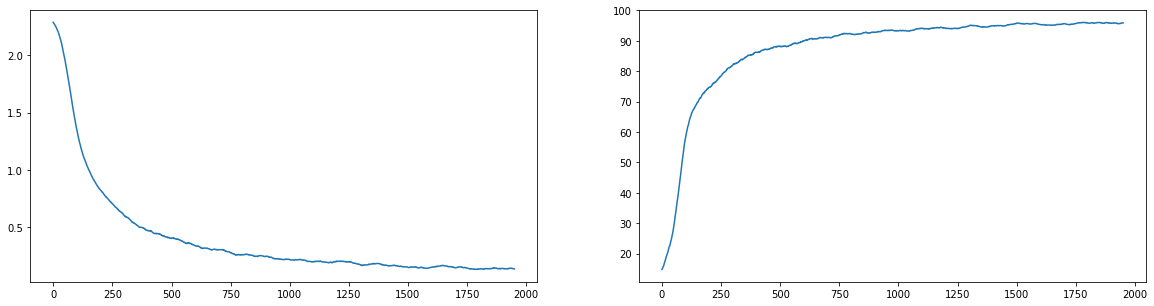

In [12]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(20,5)
ax[0].plot(running_mean(losses_relational))
ax[1].plot(running_mean(acc_relational))

In [13]:
def test_acc(model,batch_size=500):
    acc = 0.
    ids = np.random.randint(0,10000,size=10000)
    for i in range(0,10000, batch_size):
      batch_ids = ids[i: i+batch_size]
      xt = mnist_test.data[batch_ids].detach() #batch_size x 28,28
      xt = prepare_images(xt,rot=30).unsqueeze(dim=1)
      yt = mnist_test.targets[batch_ids].detach()
      preds = model(xt.to(device)).cpu()
      pred_ind = torch.argmax(preds.detach(),dim=1)
      acc += (pred_ind == yt).sum().float() 
    return acc / 10000, xt, yt

In [14]:
# def test_acc(model,batch_size=500):
#     acc = 0.
#     batch_ids = np.random.randint(0,10000,size=batch_size)
#     xt = mnist_test.data[batch_ids].detach() #batch_size x 28,28
#     xt = prepare_images(xt,rot=30).unsqueeze(dim=1)
#     yt = mnist_test.targets[batch_ids].detach()
#     preds = model(xt.cuda()).cpu()
#     pred_ind = torch.argmax(preds.detach(),dim=1)
#     acc = (pred_ind == yt).sum().float() / batch_size
#     return acc, xt, yt

In [15]:
acc_relational, xt_last, yt_last = test_acc(agent_relational)
print(acc_relational)

tensor(0.9616)


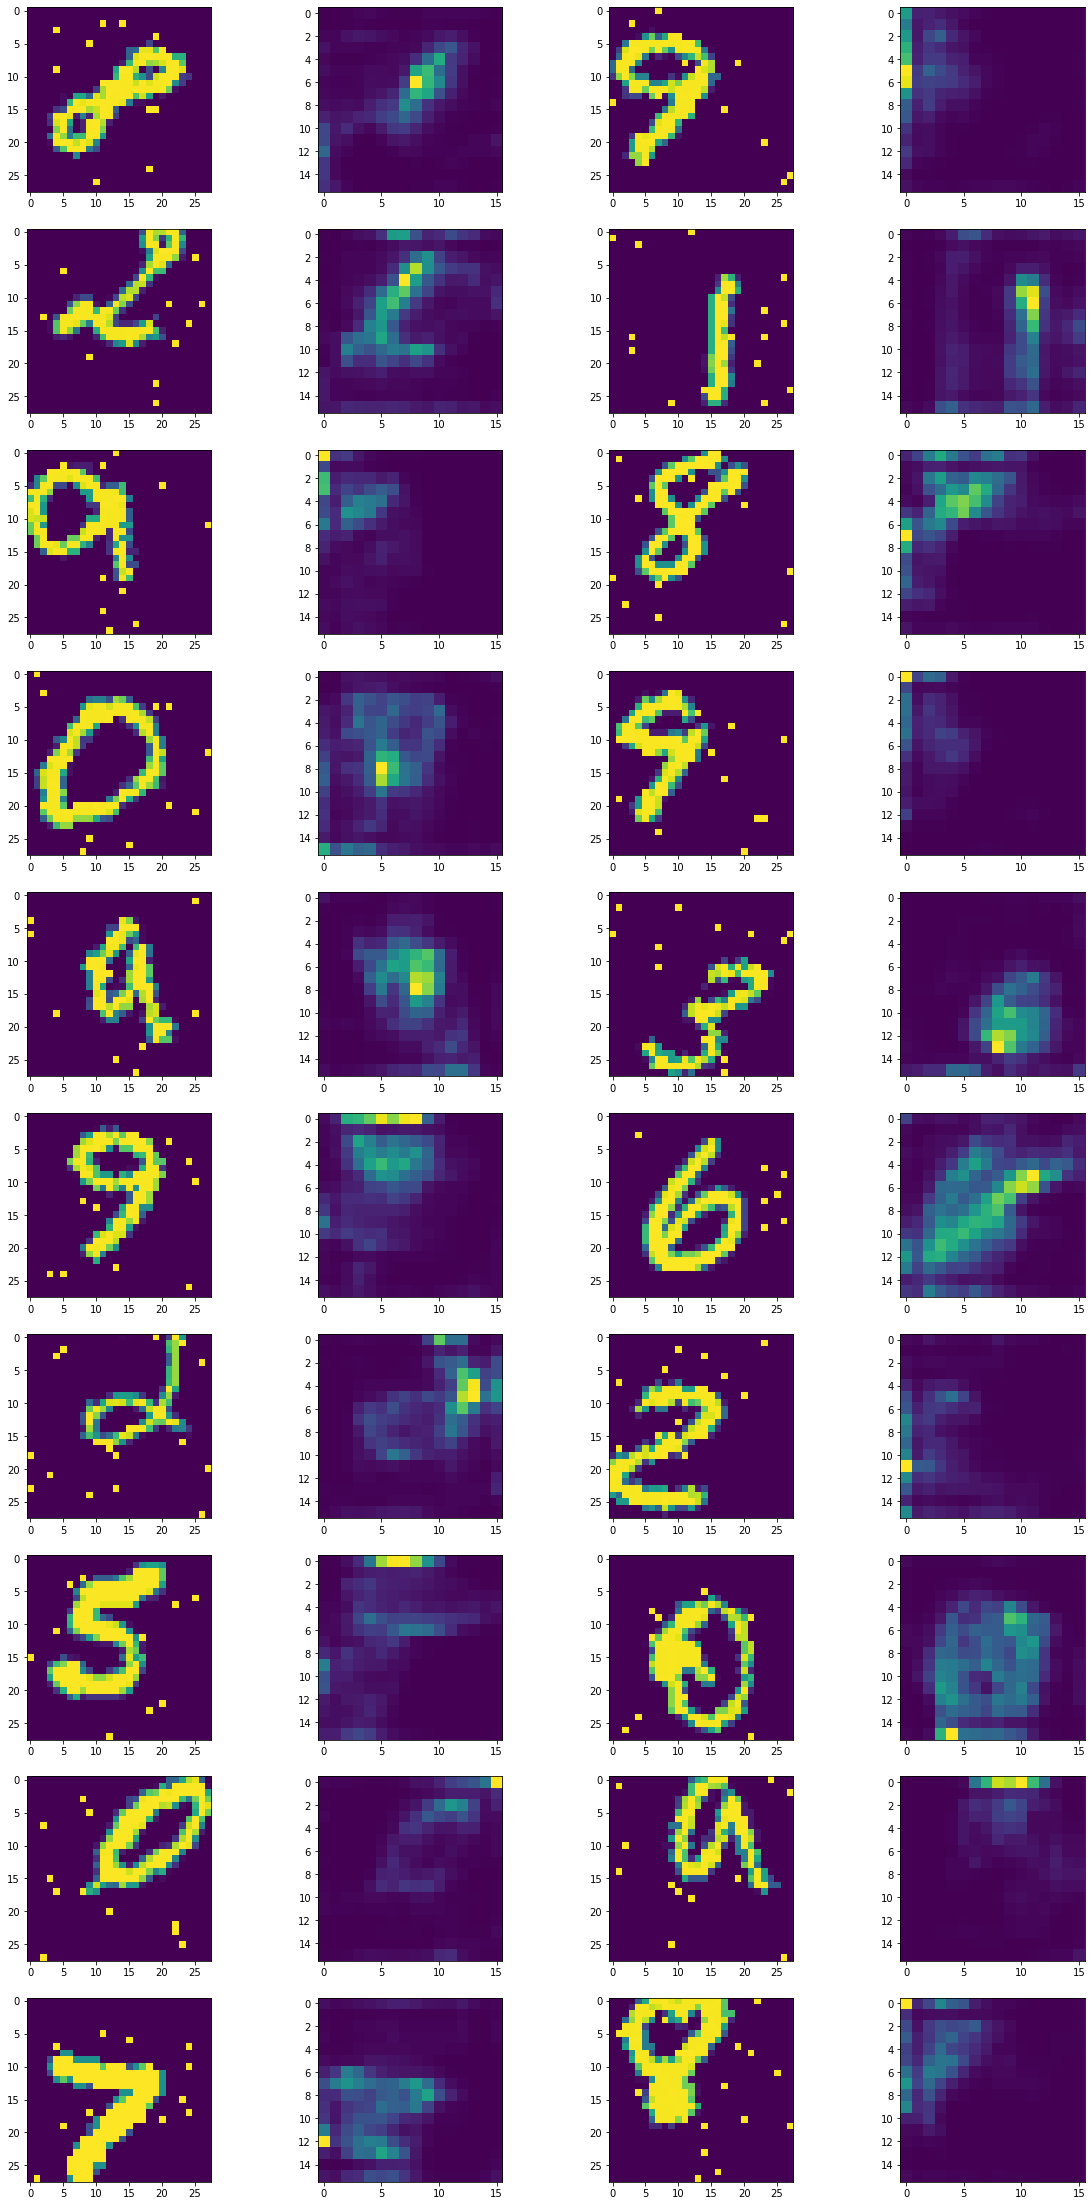

In [16]:
plt.figure(figsize=(20,40))
j = 0
for i in range(1,41,2):
  plt.subplot(10,4,i), #plt.xticks([]), plt.yticks([])
  plt.imshow(xt_last[j][0])
  plt.subplot(10,4, i + 1), #plt.xticks([]), plt.yticks([])
  att = agent_relational.att_map.cpu()[j].mean(dim=0).view(16,16)
  plt.imshow(att)
  j = j + 1

In [17]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=(4,4))
        self.conv2 = nn.Conv2d(10,16,kernel_size=(4,4))
        self.conv3 = nn.Conv2d(16,24,kernel_size=(4,4))
        self.conv4 = nn.Conv2d(24,32,kernel_size=(4,4))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2)) 
        self.conv5 = nn.Conv2d(32,64,kernel_size=(4,4))
        self.lin1 = nn.Linear(256,128)
        self.out = nn.Linear(128,10) 
    def forward(self,x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.conv5(x)
        x = nn.functional.relu(x)
        x = x.flatten(start_dim=1)
        x = self.lin1(x)
        x = nn.functional.relu(x)
        x = self.out(x)
        x = nn.functional.log_softmax(x,dim=1)
        return x

In [18]:
%%time
agent_cnn = CNN().to(device)
#Test train on MNIST

agent_cnn, losses_cnn, acc_cnn = train(agent_cnn)

100%|██████████| 2000/2000 [04:15<00:00,  7.82it/s]

CPU times: user 4min 14s, sys: 1.87 s, total: 4min 16s
Wall time: 4min 15s


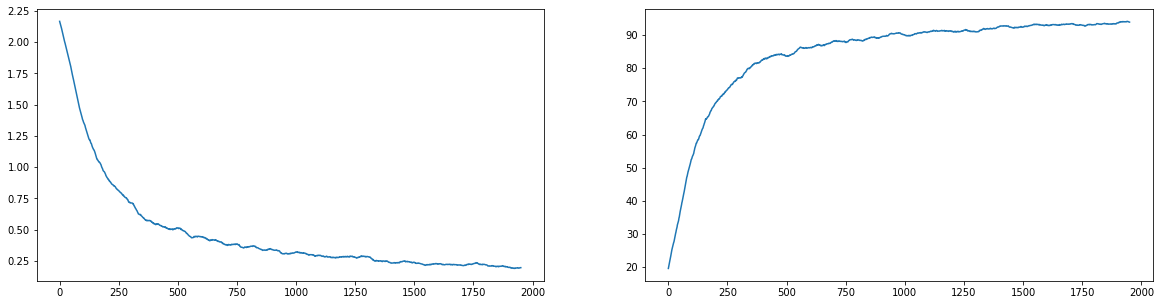

In [19]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(20,5)
ax[0].plot(running_mean(losses_cnn))
ax[1].plot(running_mean(acc_cnn))

In [20]:
acc_cnn, _,_  = test_acc(agent_cnn)
print(acc_cnn)

tensor(0.9391)
